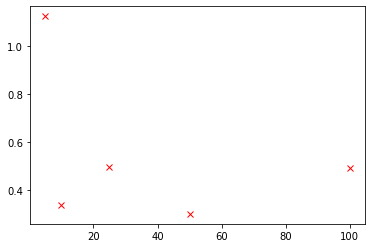

In [1]:
%reset -f

import sys

NAVBENCH_PATH = '../navbench'
sys.path.append(NAVBENCH_PATH)

import json
import os
import matplotlib.pyplot as plt

def read_json(filepath):
    file = open(filepath, "r")
    data = json.load(file)["data"]
    file.close()
    return data

data = read_json('benchmark_infomax_multi.json')

comp_time = [expt['testing']['time_per_image_ms'] for expt in data['experiments']]
plt.plot(data['num_hiddens'], comp_time, 'rx');

Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset1...
Database contains 411 images
Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset2...
Database contains 367 images
Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset3...
Database contains 402 images


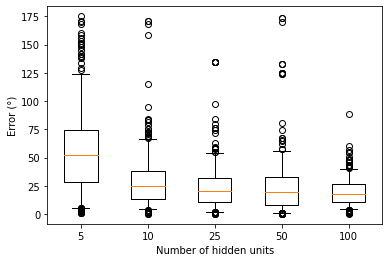

In [6]:
import navbench as nb
import numpy as np

# _, ax = plt.subplots()

DB_ROOT = os.path.join(NAVBENCH_PATH, "datasets/rc_car/Stanmer_park_dataset")

x_train = []
y_train = []
heads_train = []
for dbname in data['experiments'][0]['training']['routes']:
    db = nb.Database(os.path.join(DB_ROOT, dbname))
    offset = db.calculate_heading_offset(0.25)

    # step = 20
    # heads = np.deg2rad(db.heading[::step]) + offset
    # u = np.sin(heads)
    # v = np.cos(heads)
    # ax.quiver(db.x[::step], db.y[::step], u, v, color='blue')

    for x in db.x:
        x_train.append(x)
    for y in db.y:
        y_train.append(y)
    
    cur_heads = np.deg2rad(db.heading) + offset
    for head in cur_heads:
        heads_train.append(head)
x_train = np.array(x_train)
y_train = np.array(y_train)
heads_train = np.array(heads_train)

db_test = nb.Database(os.path.join(DB_ROOT, data['experiments'][0]['testing']['routes'][0]))
offset = db.calculate_heading_offset(0.25)

errors = np.empty((len(db_test), len(data['experiments'])))
for expt_idx, expt in enumerate(data['experiments']):
    heads = offset + np.deg2rad(expt['testing']['headings_deg'])
    for entry, (x, y, head) in enumerate(zip(db_test.x, db_test.y, heads)):
        distances = np.abs(np.hypot(x - x_train, y - y_train))
        best_match = np.argmin(distances)
        
        error = np.rad2deg(head - heads_train[best_match])
        while error > 180:
            error -= 360
        while error <= -180:
            error += 360
        error = np.abs(error)
        # print("%3i %5f %5f %5f" % (best_match, head, heads_train[best_match], error))
        errors[entry, expt_idx] = error
    # print(np.rad2deg(errors))
    # plt.plot(errors)

    # step = 20
    # heads = np.deg2rad(heads[::step]) + offset
    # u = np.sin(heads)
    # v = np.cos(heads)
    # ax.quiver(db_test.x[::step], db_test.y[::step], u, v, color='red')
    # break

fig, ax = plt.subplots()
ax.boxplot(errors, whis=(5, 95))
ax.set_xticklabels(data['num_hiddens'])
ax.set_xlabel('Number of hidden units')
ax.set_ylabel('Error (°)');

# # for i in range(5):
# #     print(np.median(errors[:,i]))
# print(errors)

# # _, ax2 = plt.subplots()
# # p95 = []
# # for i in range(5):
# #     p95.append(np.percentile(errors[:,i], 75))
# # print(p95)
# # ax2.plot(p95)

fig.savefig('figures/num_hidden_boxplot.pdf', bbox_inches='tight')